# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Regressão Linear

In [2]:
class BayesianLinearRegression:
  def __init__(self, alpha=10, epsilon=1):
    self.alpha = alpha
    self.epsilon = epsilon # TODO: Verificar se esta variável está corretamente nomeada

  def fit(self, X, y):
    # Adding Bias Column
    X = np.c_[np.ones((X.shape[0],1)), X] # (D x N)
    N = X.shape[1] # Bias included

    # Step 1: Prior
    self.m0 = np.zeros((N, 1))             # Mean: (N x 1)
    self.S0 = (self.alpha**-1) * np.eye(N) # Covavriance Matrix: (N x N)

    # Step 2: Posterior
    self.mu  = self.m0 + np.linalg.inv(self.S0 @ X.T @ X + (self.epsilon * np.eye(N))) @ self.S0 @ X.T @ (y - X @ self.m0) # Mean: (N x 1)
    self.cov = self.S0 - np.linalg.inv(self.S0 @ X.T @ X + (self.epsilon * np.eye(N))) @ self.S0 @ X.T @ X @ self.S0       # Covariance Matrix: (N x N)
      
  def predict(self, X, use_prior=False):
    # Addind Bias Column
    X = np.c_[np.ones((X.shape[0],1)), X] # (D x N)
    D = X.shape[0] # Bias included
    
    # Base
    mean = self.mu  if not use_prior else self.m0 # Coefficients
    cov  = self.cov if not use_prior else self.S0
    
    # Debug
    # print(X.shape, mean.shape, cov.shape)
    
    # Prediction
    pred = X @ mean # (N x 1)
    var  = X @ cov @ X.T
    noise = self.epsilon * np.eye(D)
    
    return pred, var, var + noise
  
  def __str__(self):
    return f'BayesianLinearRegression: \n(alpha → {self.alpha}) (epsilon → {self.epsilon}) \n(coefs → {self.mu.ravel() if hasattr(self, "mu") else None})'

#### Carregamento dos dados

In [3]:
# Data
data = np.genfromtxt('./files/linear_regression_data.csv', delimiter=',')

# Separation
X = data[:, :-1]
y = data[:, -1:]

# Normalization (Z-score)
mean = np.mean(X, axis=0)
std  = np.std(X, axis=0)
X = (X - mean) / std

#
X.shape, y.shape

((10, 1), (10, 1))

#### Training

In [4]:
# Training
bregr = BayesianLinearRegression(alpha=.1, epsilon=2.5)
%time bregr.fit(X, y)

CPU times: user 204 µs, sys: 9 µs, total: 213 µs
Wall time: 218 µs


#### Prior

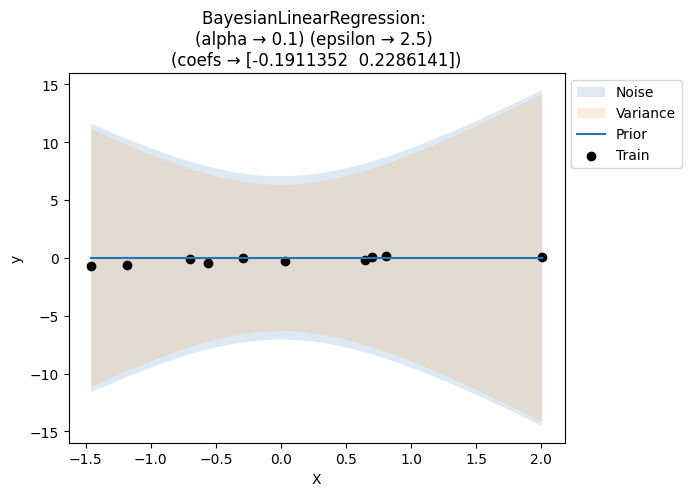

In [5]:
# Prior
X_test = np.linspace(X.min(), X.max(), 100)
preds  = bregr.predict(X_test.reshape((100, 1)), use_prior=True)

y_hat = preds[0].ravel()
cov   = np.diag(preds[1])
noise = np.diag(preds[2])

# Debug
# print(len(preds), y_hat.shape, cov.shape, noise.shape)

# Plot
plt.fill_between(X_test, y_hat + (2 * np.sqrt(noise)), y_hat - (2 * np.sqrt(noise)), alpha=0.15, label='Noise')
plt.fill_between(X_test, y_hat + (2 * np.sqrt(cov)  ), y_hat - (2 * np.sqrt(cov)  ), alpha=0.15, label='Variance')
plt.plot(X_test, y_hat, label='Prior')
plt.scatter(X, y, label="Train", color="black") # Real data

plt.xlabel('X')
plt.ylabel('y')
plt.title(bregr)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

#### Posteriori

<div class="alert alert-block alert-info">NOTE: Escalas Diferentes e reuso do ruído</div>

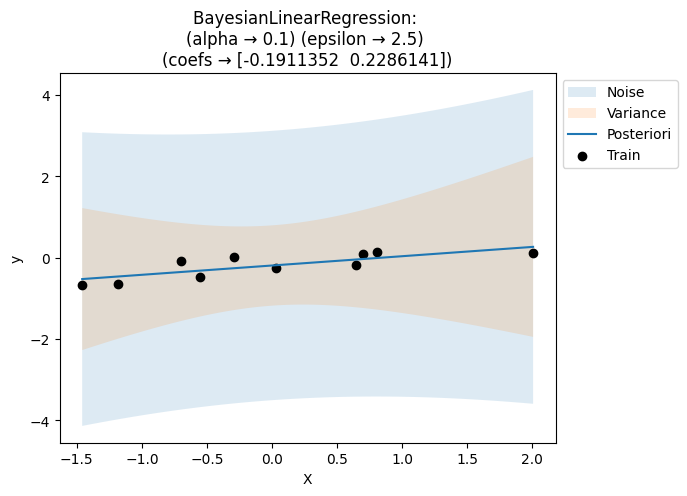

In [6]:
# Posteriori
X_test = np.linspace(X.min(), X.max(), 100)
preds  = bregr.predict(X_test.reshape((100, 1)), use_prior=False)

y_hat = preds[0].ravel()
cov   = np.diag(preds[1])
noise = np.diag(preds[2])

# Debug
# print(len(preds), y_hat.shape, cov.shape, noise.shape)

# Plot
plt.fill_between(X_test, y_hat + (2 * np.sqrt(noise)), y_hat - (2 * np.sqrt(noise)), alpha=0.15, label='Noise')
plt.fill_between(X_test, y_hat + (2 * np.sqrt(cov)  ), y_hat - (2 * np.sqrt(cov)  ), alpha=0.15, label='Variance')
plt.plot(X_test, y_hat, label='Posteriori')
plt.scatter(X, y, label="Train", color="black") # Real data


plt.xlabel('X')
plt.ylabel('y')
plt.title(bregr)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

## Regressão Polinomial

> Dessa vez eu não usarei PolynomialFeatures 😂

In [7]:
def build_polynom(X, order=2):
  output = X.copy()
  
  for d in range(2, order + 1):
    output = np.c_[output, X**d]
    
  return output


#### Carregamento dos dados

In [8]:
ORDER = 6 # Pelos dados não posso afirmar muito sobre esse grau do polinômio

# Data
data = np.genfromtxt('./files/polynomial_regression_data.csv', delimiter=',')

# Separation
X = data[:, :-1]
y = data[:, -1:]

# Build polynom
polyX = build_polynom(X, order=ORDER)
#
X.shape, y.shape, polyX.shape

((10, 1), (10, 1), (10, 6))

#### Training

In [9]:
# Training
bregr = BayesianLinearRegression(alpha=.1, epsilon=2.5)
%time bregr.fit(polyX, y)

CPU times: user 169 µs, sys: 0 ns, total: 169 µs
Wall time: 173 µs


#### Prior

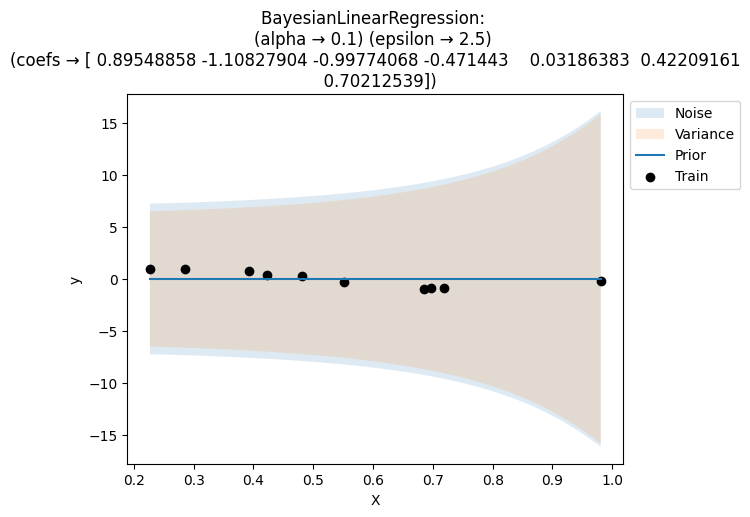

In [10]:
# Prior
X_test = np.linspace(X.min(), X.max(), 100)
polyX_test = build_polynom(np.linspace(X.min(), X.max(), 100), order=ORDER)
preds  = bregr.predict(polyX_test, use_prior=True)

y_hat = preds[0].ravel()
cov   = np.diag(preds[1])
noise = np.diag(preds[2])

# Debug
# print(len(preds), y_hat.shape, cov.shape, noise.shape, X_test.shape)

# Plot
plt.fill_between(X_test, y_hat + (2 * np.sqrt(noise)), y_hat - (2 * np.sqrt(noise)), alpha=0.15, label='Noise')
plt.fill_between(X_test, y_hat + (2 * np.sqrt(cov)  ), y_hat - (2 * np.sqrt(cov)  ), alpha=0.15, label='Variance')
plt.plot(X_test, y_hat, label='Prior')
plt.scatter(X, y, label="Train", color="black") # Real data

plt.xlabel('X')
plt.ylabel('y')
plt.title(bregr)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

#### Posteriori

<div class="alert alert-block alert-info">Escalas Diferentes e Reuso do Ruído</div>

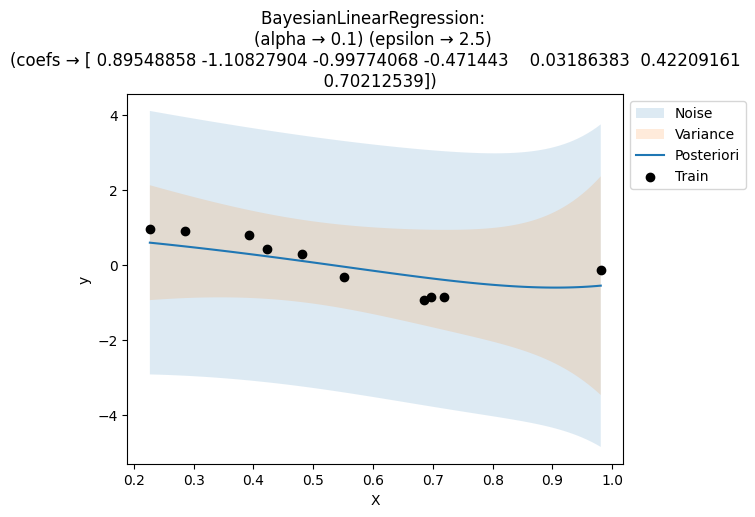

In [11]:
# Prior
X_test = np.linspace(X.min(), X.max(), 100)
polyX_test = build_polynom(np.linspace(X.min(), X.max(), 100), order=ORDER)
preds  = bregr.predict(polyX_test, use_prior=False)

y_hat = preds[0].ravel()
cov   = np.diag(preds[1])
noise = np.diag(preds[2])

# Debug
# print(len(preds), y_hat.shape, cov.shape, noise.shape)

# Plot
plt.fill_between(X_test, y_hat + (2 * np.sqrt(noise)), y_hat - (2 * np.sqrt(noise)), alpha=0.15, label='Noise')
plt.fill_between(X_test, y_hat + (2 * np.sqrt(cov)  ), y_hat - (2 * np.sqrt(cov)  ), alpha=0.15, label='Variance')
plt.plot(X_test, y_hat, label='Posteriori')
plt.scatter(X, y, label="Train", color="black") # Real data

plt.xlabel('X')
plt.ylabel('y')
plt.title(bregr)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

## Regressão Logística

In [12]:
class BayesianLogisticRegression:
  def __init__(self, max_epochs=10, min_diff=10**-1, size=50, seed=42):
    self.max_epochs = max_epochs
    self.min_diff = min_diff
    self.size = max(1, size)
    self.seed = seed
  
  def fit(self, X, y):
    # Adding Bias Column
    X = np.c_[np.ones((X.shape[0], 1)), X] # (D x N)
    N = X.shape[1] # Bias included

    # Step 1: Prior
    self.m0 = np.zeros((N, 1)) # Mean: (N x 1)
    self.S0 = np.eye(N)        # Covariance Matrix: (N x N). Note: in this case S0 == np.linalg.inv(S0)

    # Step 2: Posteriori - MAP solution by Iterative Reweighted Least Squares Method
    self.mu = np.zeros((N, 1))

    # Stop conditions
    epoch, diff = 0, np.inf
    
    while epoch < self.max_epochs and diff > self.min_diff:      
      # R
      tmp = self.activation(np.sum(self.mu.T * X, axis=1))
      R = np.diag(tmp * (1 - tmp))
      
      # A
      A = X.T @ R @ X + self.S0
      
      # Update
      wt = self.mu + np.linalg.inv(A) @ (X.T @ (y - self.activation(X @ self.mu)) - self.S0 @ (self.mu - self.m0))
      self.mu, diff = wt, np.linalg.norm(wt - self.mu)
      
      # Increment
      epoch += 1 
    
    #
    tmp = self.activation(np.sum(self.mu.T * X, axis=1))
    H = np.diag(tmp * (1 - tmp))

    #
    self.cov = np.linalg.inv(X.T @ H @ X + self.S0)
    
    # Monte Carlo Sample
    np.random.seed(self.seed)
    self.ws = np.random.multivariate_normal(mean=self.mu.reshape(-1), cov=self.cov, size=self.size).T

  def predict_proba(self, X):
    # Addind Bias Column
    X = np.c_[np.ones((X.shape[0],1)), X] # (D x N)
    D = X.shape[0] # Bias included
    
    # Prediction
    return np.mean([self.activation(self.ws.T @ x) for x in X], axis=1)
  
  def predict(self, X, R_cost=1):
    ''' R_cost: Decision Limiar '''
    
    return np.where(self.predict_proba(X) > 1/(R_cost + 1), 1, 0)
  
  #
  @staticmethod
  def activation(z):
      ''' Sigmoid function '''
      return 1/(1 + np.exp(-z))
    
  def __str__(self):
    return f'BayesianLogisticRegression'

#### Carregamento dos dados

In [13]:
# Data
data = np.genfromtxt('./files/logistic_regression_data.csv', delimiter=',')

# Separation
X = data[:, :-1]
y = data[:, -1:]

# Normalization (Z-score)
mean = np.mean(X, axis=0)
std  = np.std(X, axis=0)
X = (X - mean) / std

#
X.shape, y.shape


((100, 2), (100, 1))

#### Training

In [14]:
# Training
blogist = BayesianLogisticRegression()
%time blogist.fit(X, y)

CPU times: user 11.8 ms, sys: 4.77 ms, total: 16.6 ms
Wall time: 23 ms


 #### Plot


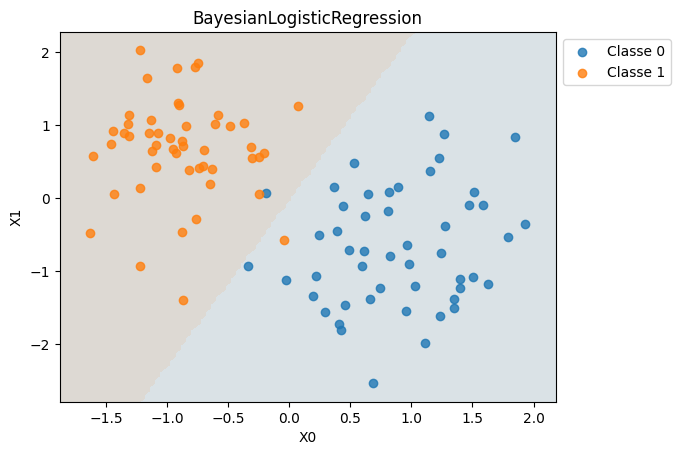

In [ ]:
# Special thanks to Mr. Gemini
xx, yy = np.meshgrid(
  np.linspace(X[:, 0].min() - 0.25, X[:, 0].max() + 0.25, 100), 
  np.linspace(X[:, 1].min() - 0.25, X[:, 1].max() + 0.25, 100)) # Não me pergunte

X_test = np.c_[xx.ravel(), yy.ravel()]

#
Z = blogist.predict(X_test).reshape(xx.shape) 

# Custom color map
cmap = mcolors.LinearSegmentedColormap.from_list('Custom', ['#d8e7f0', '#ded5ca'])

# Contour
plt.contourf(xx, yy, Z, cmap=cmap, levels=[-1, 0, 1])

# Scatters
plt.scatter(X[(y==0).ravel()][:, 0], X[(y==0).ravel()][:, 1], alpha=0.8, label="Classe 0")
plt.scatter(X[(y==1).ravel()][:, 0], X[(y==1).ravel()][:, 1], alpha=0.8, label="Classe 1")

#
plt.xlabel('X0')
plt.ylabel('X1')
plt.title(blogist)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()